# BE Machine Learning
## Bitcoin Heist


#### On choisit une detection d'annomalie
 
On ne sait pas quel va etre le type du prochain ransomware donc on prefere etre sur de detecetr un white que essayer de chercher les ransomware


In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Lecture du csv 


In [3]:
# load the dataset in a pandas DataFrame
df = pd.read_csv('data/BitcoinHeistData.csv')

In [4]:
# first visualization
print(f"dataset shape: {df.shape}")
print(f"columns names: {df.columns.tolist()}")
print(df.head())

labels_names = df['label'].unique().tolist()
print(labels_names)

dataset shape: (2916697, 10)
columns names: ['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income', 'label']
                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0          2  100050000.0  princetonCerber  
1       0          1  100000000.0   princetonLocky  
2       0          2  200000000.0  princetonCerber  
3       0          2   71200000.0  princetonCerber  
4       0          1  200000000.0   princetonLocky  
['princetonCerber', 'princetonLocky', 'montrealCryptoLocker', 'montrealCryptX

### Traitement des données

On change les label pour etre 0 si c'est white ou 1 si c'est un ransomware

In [ ]:
# Ajout de la colonne binaire y: 0 pour white, 1 pour ransomware
df['y'] = (df['label'] != 'white').astype(int)
df_white = df[df['y'] == 0]
df_ransomware = df[df['y'] == 1]
print(f"il y a {len(df_white)} adresses blanches et {len(df_ransomware)} ransomwares")
print(f"proportion de ransomwares: {len(df_ransomware) / len(df):.4f}%")

il y a 2875284 adresses blanches et 41413 ransomwares
proportion de ransomwares: 0.0142


On créé maintenant les X et y

In [25]:
# On ne garde que les features qui nous interessent pour la classification
features = ['length','weight','count','looped','neighbors','income']
X = df[features].copy()
y = df['y'].values


scaler = StandardScaler()
X = scaler.fit_transform(X.values)
print(X[100:120,:])
print(y[100:110])

# A changer et rééquilibrer les données
# X[['income', 'weight', 'count', 'length']] = np.log1p(X[['income', 'weight', 'count', 'length']])


[[ 1.67832247 -0.13750328  0.80273127 -0.24681919 -0.06733256 -0.0271375 ]
 [-0.76308576 -0.0123887  -0.42649884 -0.24681919 -0.06733256 -0.02523205]
 [-0.76308576  0.12369332 -0.42649884 -0.24681919 -0.06733256 -0.02648336]
 [ 1.67832247 -0.07677367  1.43598895 -0.24681919 -0.01152513 -0.02621555]
 [-0.76308576 -0.0123887  -0.42649884 -0.24681919 -0.06733256 -0.02498611]
 [-0.72917731 -0.14661295 -0.42413152 -0.24681919 -0.06733256 -0.02648249]
 [ 1.47487179 -0.14847072 -0.42649884 -0.24681919 -0.01152513 -0.02683016]
 [-0.76308576 -0.0123887  -0.42649884 -0.24681919 -0.01152513 -0.02670722]
 [-0.08491681 -0.1484698  -0.42649884 -0.24681919 -0.01152513 -0.02560894]
 [ 1.67832247  0.84955929  0.90511779 -0.24474949  0.21170457 -0.02595743]
 [-0.72917731 -0.12903043 -0.42649884 -0.24681919 -0.06733256 -0.02590813]
 [-0.76308576  0.12369332 -0.42649884 -0.24681919 -0.01152513 -0.02695309]
 [-0.76308576 -0.11445022 -0.42649884 -0.24681919 -0.01152513 -0.02560079]
 [-0.76308576 -0.05774937

In [26]:
# divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_white_train = X_train[y_train == 0]
X_ransomware_train = X_train[y_train == 1]

## Visualisation des données pour mieux comprendre 


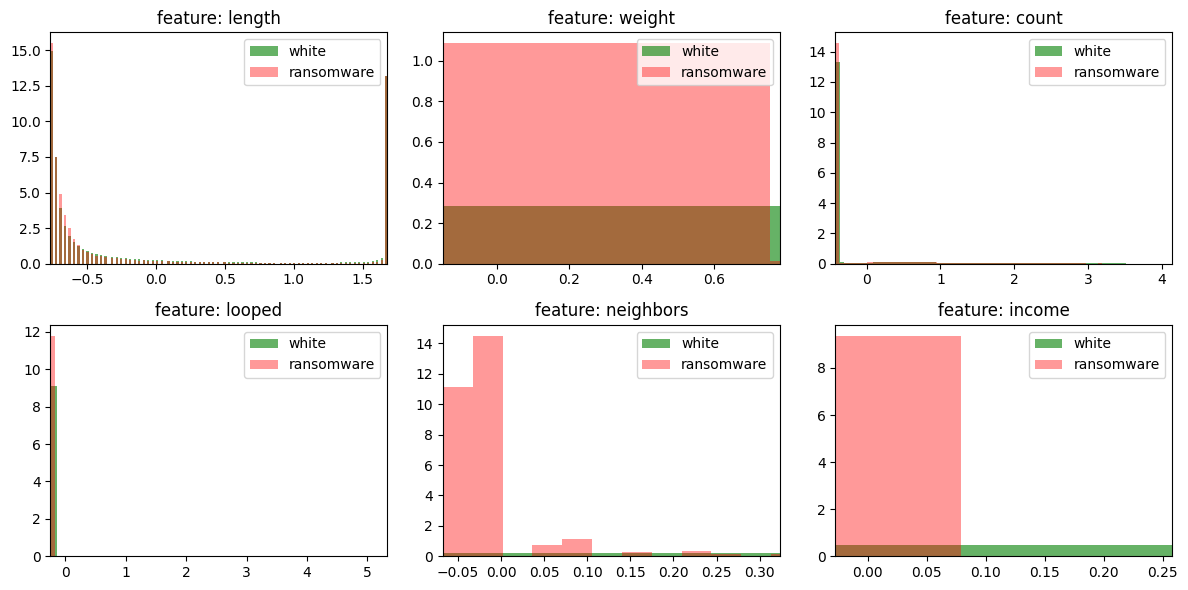

In [ ]:
# On plot les distributions des features
fig, axes = plt.subplots(2,3, figsize=(12,6))
axs = axes.flatten()

use_percentile = True

if use_percentile:
    # permet de ne pas prendre en compte les outliers dans le plot
    xmin = np.percentile(X, 1, axis=0)   # 1er percentile par feature
    xmax = np.percentile(X, 99, axis=0)  # 99ème percentile par feature
else:
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)

for i, feature in enumerate(features):
    axs[i].hist(X[y==0, i], bins=150, density=True, color='g', alpha=0.6, label='white')
    axs[i].hist(X[y==1, i], bins=150, density=True, color='r', alpha=0.4, label='ransomware')
    axs[i].set_title(f'feature: {feature}')
    axs[i].set_xlim(xmin[i], xmax[i])   # calibration avec xmin/xmax
    axs[i].legend()

plt.tight_layout()
plt.show()

In [115]:
ransomware = 0
white = 0
for i, income in enumerate(X[:,5]):
    if income < 0.075:
        if y[i]== 1:
            ransomware +=1
        else:
            white +=1
print(f"nombre de ransomwares avec un income < 0.075: {ransomware}")
print(f"nombre de white avec un income < 0.075: {white}")

nombre de ransomwares avec un income < 0.075: 41222
nombre de white avec un income < 0.075: 2794510


On remarque que **Income** nous donne un premier critère de sélection , c'est une feature très importante.

## Première idée sur Random forest -> pas fou

Importance de mettre **class_weight='balanced'**

In [ ]:
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    class_weight='balanced',  # très important car dataset déséquilibré
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


random forest name is RandomForestClassifier


AttributeError: 'RandomForestClassifier' object has no attribute '__name__'

In [ ]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("ROC-AUC :", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))


ROC-AUC : 0.8121109291959724
PR-AUC : 0.06798013097962957
              precision    recall  f1-score   support

           0     0.9954    0.6456    0.7832    575057
           1     0.0312    0.7938    0.0601      8283

    accuracy                         0.6477    583340
   macro avg     0.5133    0.7197    0.4217    583340
weighted avg     0.9817    0.6477    0.7729    583340

[[371232 203825]
 [  1708   6575]]


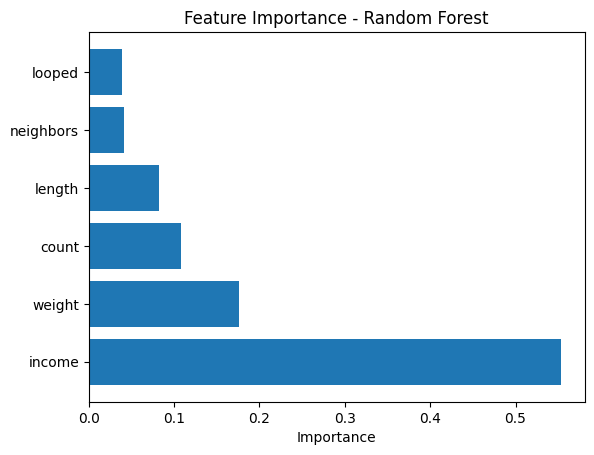

In [ ]:

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance - Random Forest")
plt.show()

PR-AUC: 0.10527308804389564


## Deuxieme idée isolate forest 

### Test Isolate forest 


In [39]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=300, contamination=0.0141, random_state=42, n_jobs=-1)
clf.fit(X_train)

,n_estimators,300
,max_samples,'auto'
,contamination,0.0141
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [ ]:

y_pred_if = clf.predict(X_test)
y_pred_if = np.where(y_pred_if == 1, 0, 1)
print(y_pred_if[:20])

print(classification_report(y_test, y_pred_if, digits=4))
print(confusion_matrix(y_test, y_pred_if).T)

[array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]), 

In [60]:
for cont in [0.0141]:
    clf = IsolationForest(n_estimators=100, contamination=cont)
    clf.fit(X_train)

    y_pred_if = clf.predict(X_test)
    y_pred_if = np.where(y_pred_if == 1, 0, 1)
    print(f"\nContamination: {cont}")
    print(classification_report(y_test, y_pred_if, digits=4))


Contamination: 0.0141
              precision    recall  f1-score   support

           0     0.9858    0.9859    0.9859    575057
           1     0.0148    0.0147    0.0148      8283

    accuracy                         0.9721    583340
   macro avg     0.5003    0.5003    0.5003    583340
weighted avg     0.9720    0.9721    0.9721    583340



In [63]:
clf = IsolationForest(n_estimators=300, max_samples='auto',
                      contamination='auto', random_state=42, n_jobs=-1)
clf.fit(X)

scores = -clf.decision_function(X)   # higher => more anomalous
X['anomaly_score'] = scores

# top-k fenêtres
k = 20
topk = X.sort_values('anomaly_score', ascending=False).head(k)
print(topk[['anomaly_score']])

# si tu connais un taux de contamination et veux classer
cont = 0.05
th = np.percentile(scores, 100*(1-cont))
y_pred = (scores >= th).astype(int)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Novelties detection

In [34]:
X_white_train = X_train[y_train == 0]
y_white_train = y_train[y_train == 0]

X_ransomware_train = X_train[y_train == 1]
y_ransomware_train = y_train[y_train == 1]


X_white_test = X_test[y_test == 0]
y_white_test = y_test[y_test == 0]

X_ransomware_test = X_test[y_test == 1]
y_ransomware_test = y_test[y_test == 1]

print(f"Training shapes: white:{X_white_train.shape}, ransomware:{X_ransomware_train.shape}")
print(f"Testing shapes: white:{X_white_test.shape}, ransomware:{X_ransomware_test.shape}")

print(X_ransomware_test.head())


Training shapes: white:(2300227, 6), ransomware:(33130, 6)
Testing shapes: white:(575057, 6), ransomware:(8283, 6)
         length    weight     count  looped  neighbors     income
1818   4.976734  0.135687  8.470521       0          1  18.826146
9296   0.000000  0.182322  0.693147       0          2  18.420681
18907  1.098612  0.405465  0.693147       0          1  19.200006
36271  1.098612  0.405465  0.693147       0          1  21.128731
4795   2.397895  0.223144  0.693147       0          2  18.661412


### test Local outlier factor


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=3, contamination=0.141, novelty=True)
clf.fit(X)
y_pred_lof = clf.predict(X)
y_pred_lof = np.where(y_pred_lof == 1, 0, 1)
print(classification_report(y, y_pred_lof, digits=4))